In [1]:
import ambulance_game as abg
import numpy as np
import math
import matplotlib.pyplot as plt

# <ins>Results:<ins>


In [2]:
lambda_a = 0.2
lambda_o = 0.3
mu = 0.2
num_of_servers = 4
threshold = 3
system_capacity = 5
parking_capacity = 5

num_of_trials = 10
seed_num = 0
runtime = 10000
output = "others"
accuracy = 10

#### Hatmaps


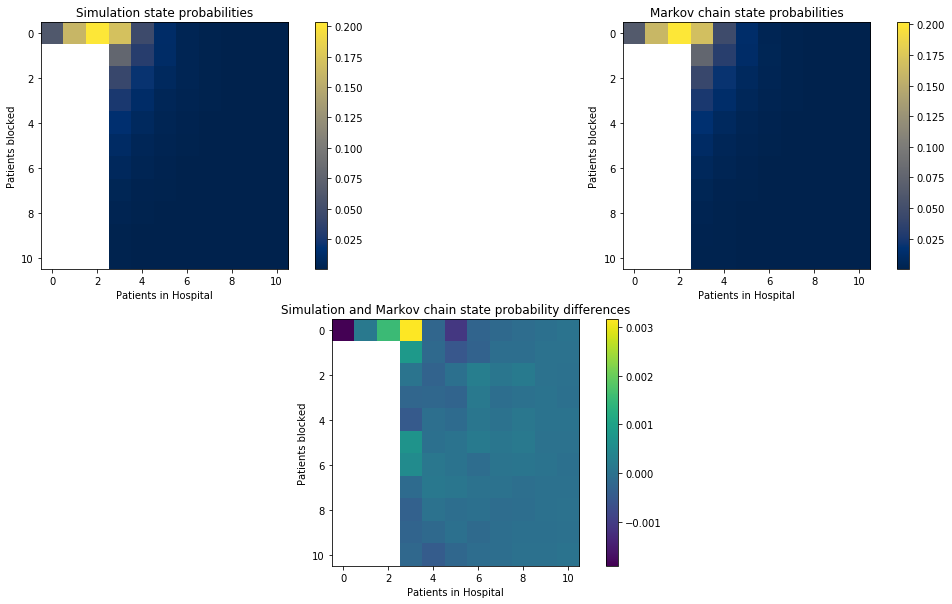

In [3]:
plt.figure(figsize=(20, 10))
abg.get_heatmaps(
    lambda_a=lambda_a,
    lambda_o=lambda_o,
    mu=mu,
    num_of_servers=num_of_servers,
    threshold=threshold,
    system_capacity=system_capacity,
    parking_capacity=parking_capacity,
    seed_num=seed_num,
    runtime=runtime,
    num_of_trials=num_of_trials,
)


#### Other patietns waiting times


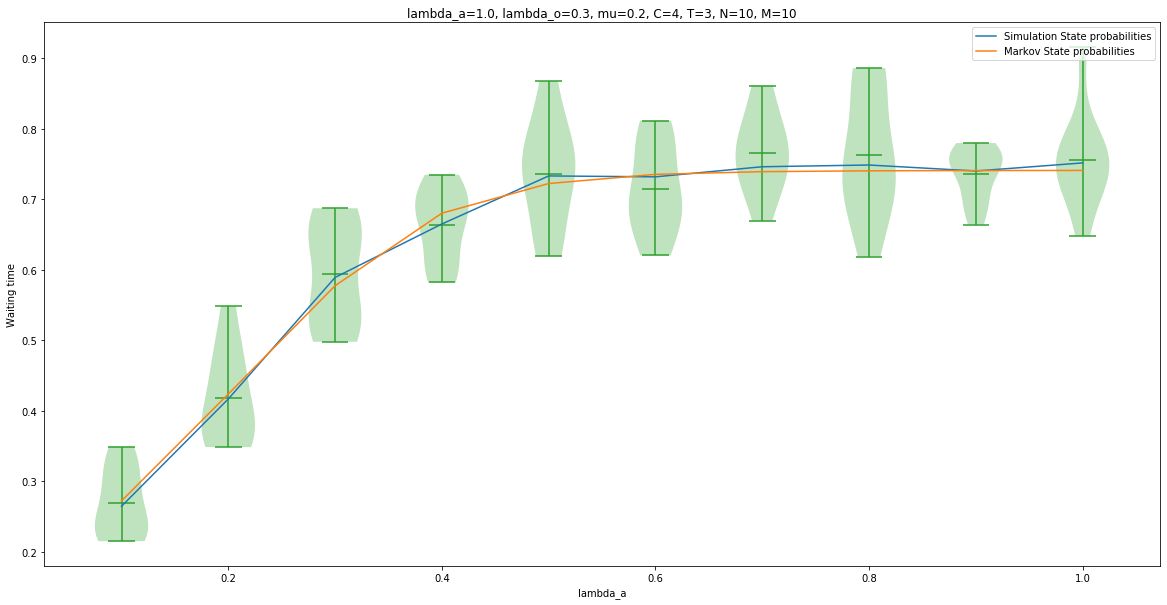

In [4]:
plot_over = "lambda_a"
max_parameter_value = 1
x_axis, mean_sim, mean_markov, all_sim = abg.get_plot_comparing_times(
    0.1,
    lambda_o,
    mu,
    num_of_servers,
    threshold,
    num_of_trials,
    seed_num,
    runtime,
    system_capacity,
    parking_capacity,
    output,
    plot_over,
    max_parameter_value,
    accuracy,
)


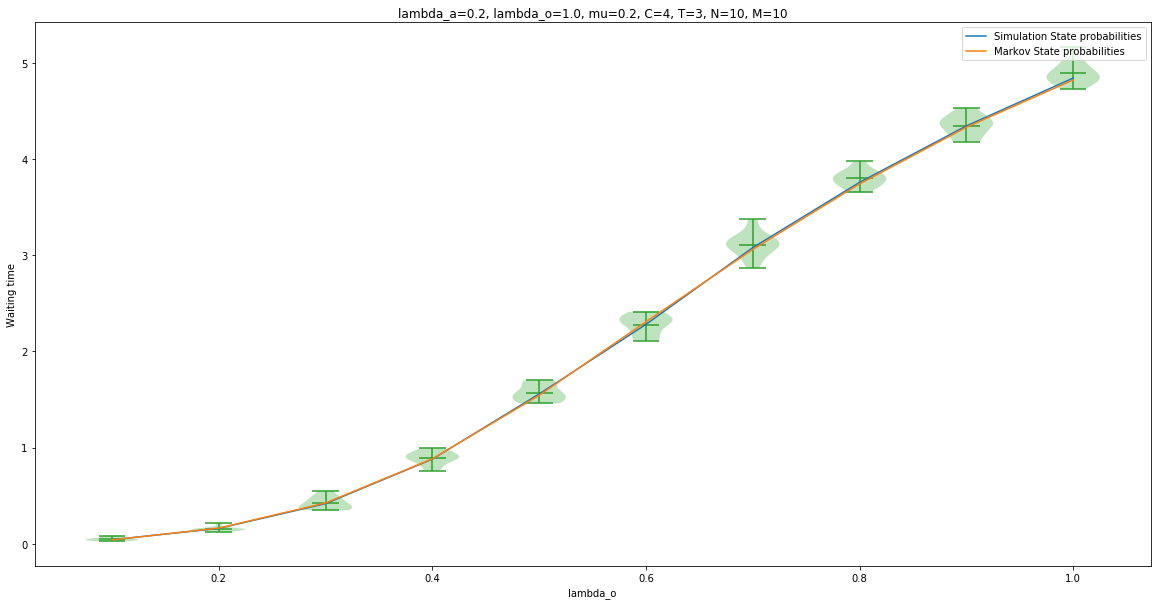

In [5]:
plot_over = "lambda_o"
max_parameter_value = 1
x_axis, mean_sim, mean_markov, all_sim = abg.get_plot_comparing_times(
    lambda_a,
    0.1,
    mu,
    num_of_servers,
    threshold,
    num_of_trials,
    seed_num,
    runtime,
    system_capacity,
    parking_capacity,
    output,
    plot_over,
    max_parameter_value,
    accuracy,
)

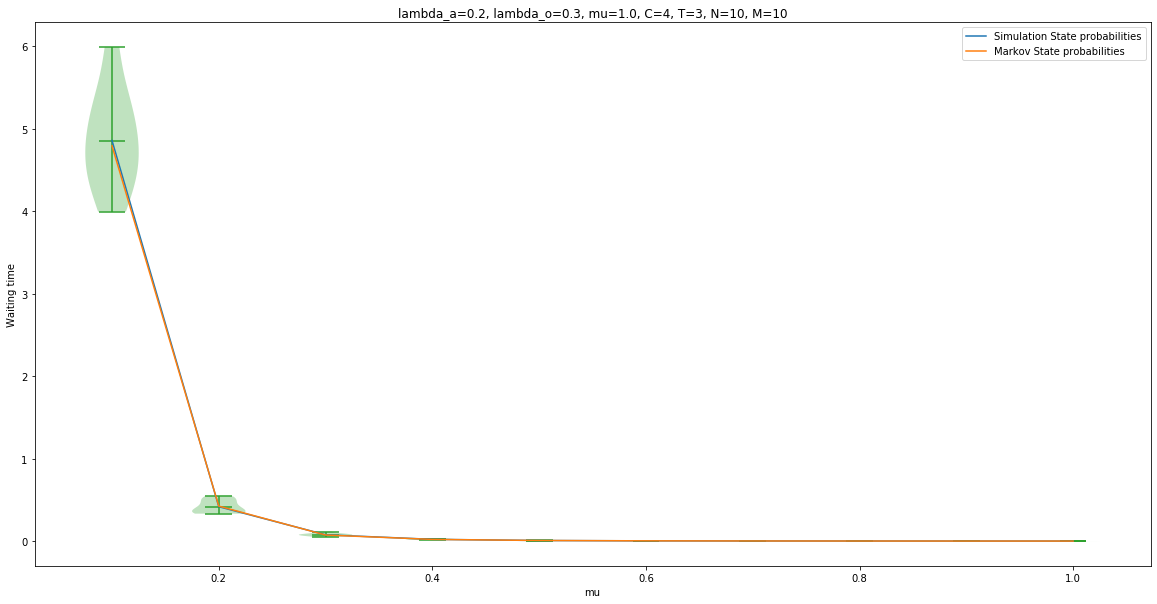

In [15]:
plot_over = "mu"
max_parameter_value = 1
x_axis, mean_sim, mean_markov, all_sim = abg.get_plot_comparing_times(
    lambda_a,
    lambda_o,
    0.1,
    num_of_servers,
    threshold,
    num_of_trials,
    seed_num,
    runtime,
    system_capacity,
    parking_capacity,
    output,
    plot_over,
    max_parameter_value,
    accuracy,
)

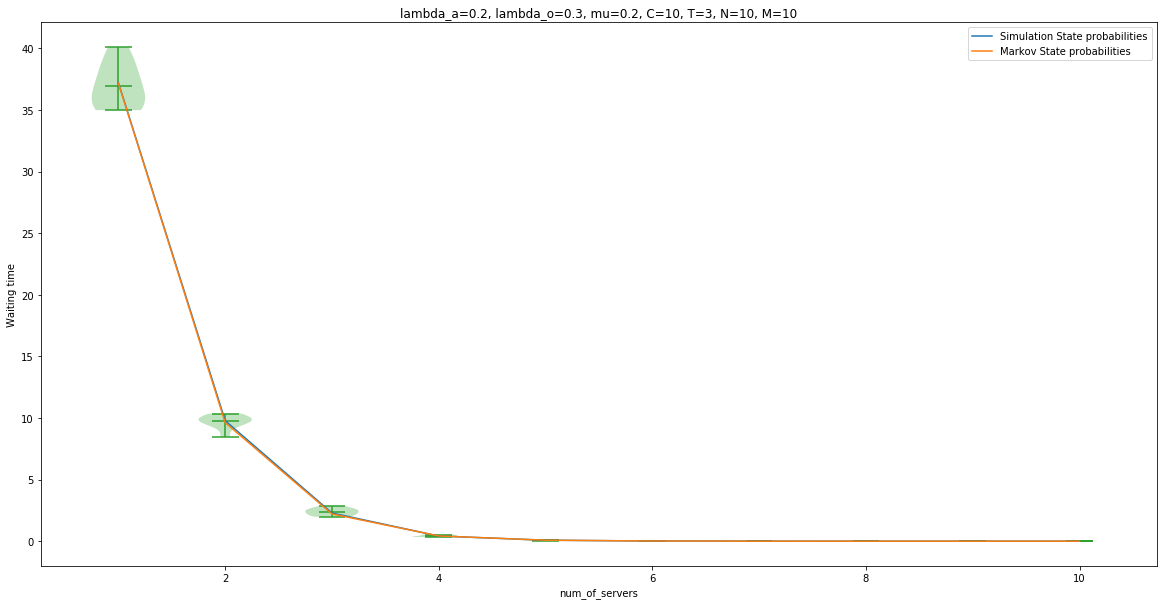

In [16]:
plot_over = "num_of_servers"
max_parameter_value = 10
x_axis, mean_sim, mean_markov, all_sim = abg.get_plot_comparing_times(
    lambda_a,
    lambda_o,
    mu,
    1,
    threshold,
    num_of_trials,
    seed_num,
    runtime,
    system_capacity,
    parking_capacity,
    output,
    plot_over,
    max_parameter_value,
    accuracy,
)


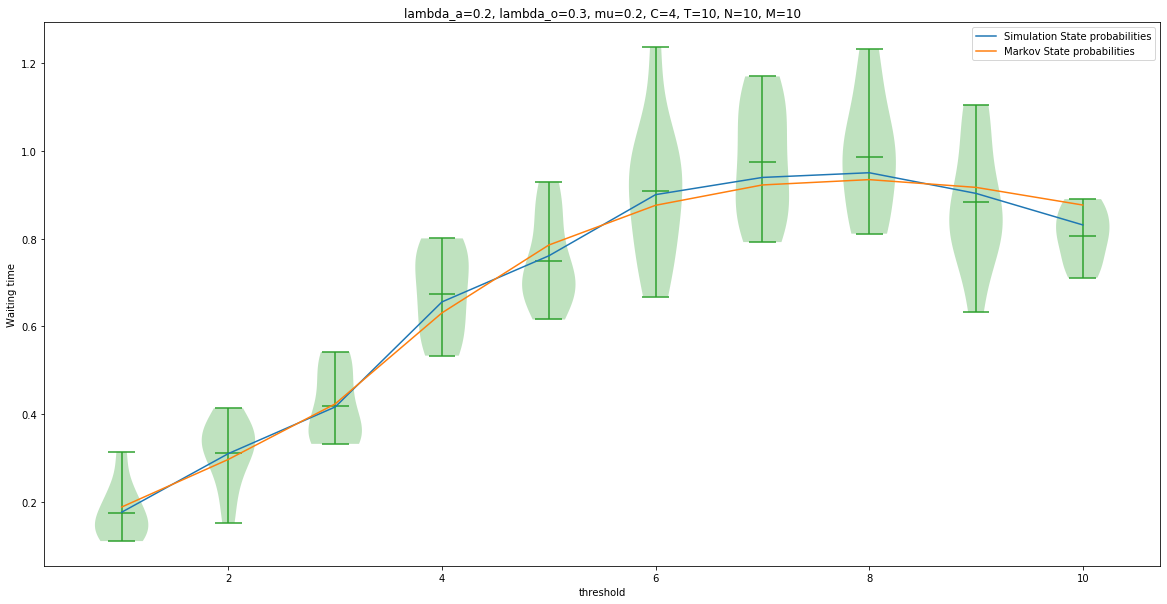

In [17]:
plot_over = "threshold"
max_parameter_value = 10
x_axis, mean_sim, mean_markov, all_sim = abg.get_plot_comparing_times(
    lambda_a,
    lambda_o,
    mu,
    num_of_servers,
    1,
    num_of_trials,
    seed_num,
    runtime,
    system_capacity,
    parking_capacity,
    output,
    plot_over,
    max_parameter_value,
    accuracy,
)


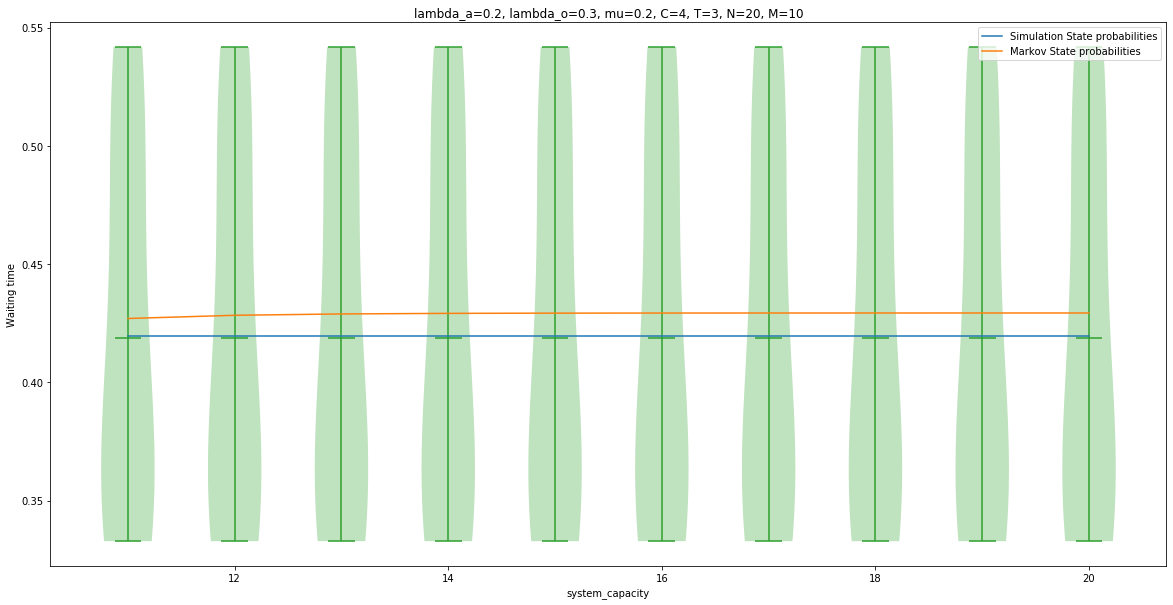

In [18]:
plot_over = "system_capacity"
max_parameter_value = 20
x_axis, mean_sim, mean_markov, all_sim = abg.get_plot_comparing_times(
    lambda_a,
    lambda_o,
    mu,
    num_of_servers,
    threshold,
    num_of_trials,
    seed_num,
    runtime,
    11,
    parking_capacity,
    output,
    plot_over,
    max_parameter_value,
    accuracy,
)


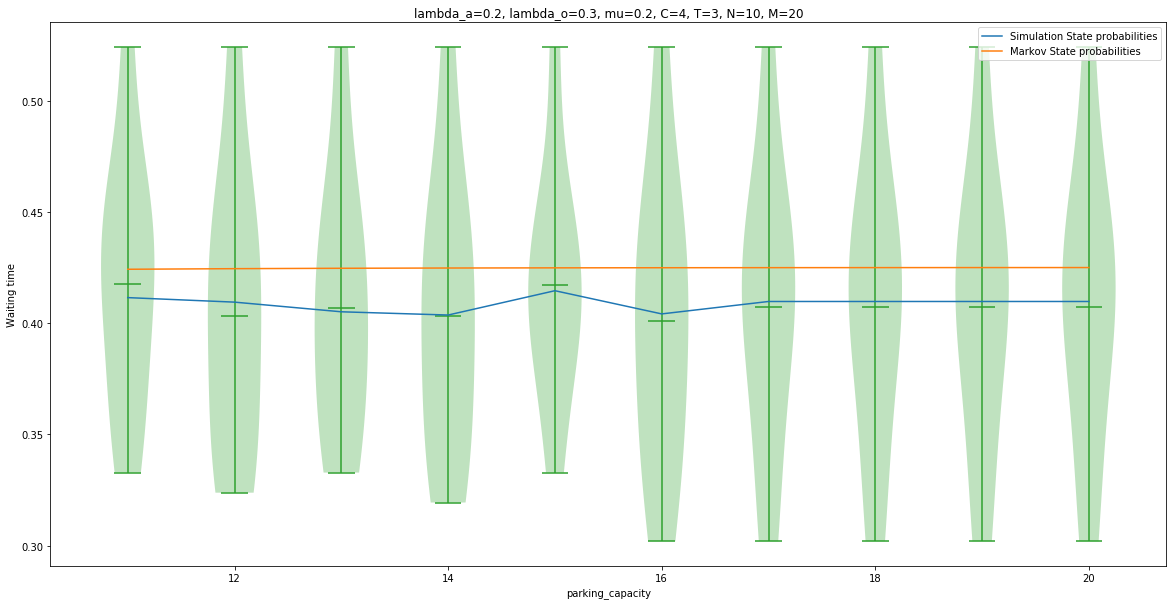

In [19]:
plot_over = "parking_capacity"
max_parameter_value = 20
x_axis, mean_sim, mean_markov, all_sim = abg.get_plot_comparing_times(
    lambda_a,
    lambda_o,
    mu,
    num_of_servers,
    threshold,
    num_of_trials,
    seed_num,
    runtime,
    system_capacity,
    11,
    output,
    plot_over,
    max_parameter_value,
    accuracy,
)


#### Ambulance patients waiting times:


In [21]:
lambda_a = 0.2
lambda_o = 0.3
mu = 0.2
num_of_servers = 5
threshold = 6
system_capacity = 20
parking_capacity = 20

num_of_trials = 10
seed_num = 0
runtime = 5000
output = "ambulance"
accuracy = 10


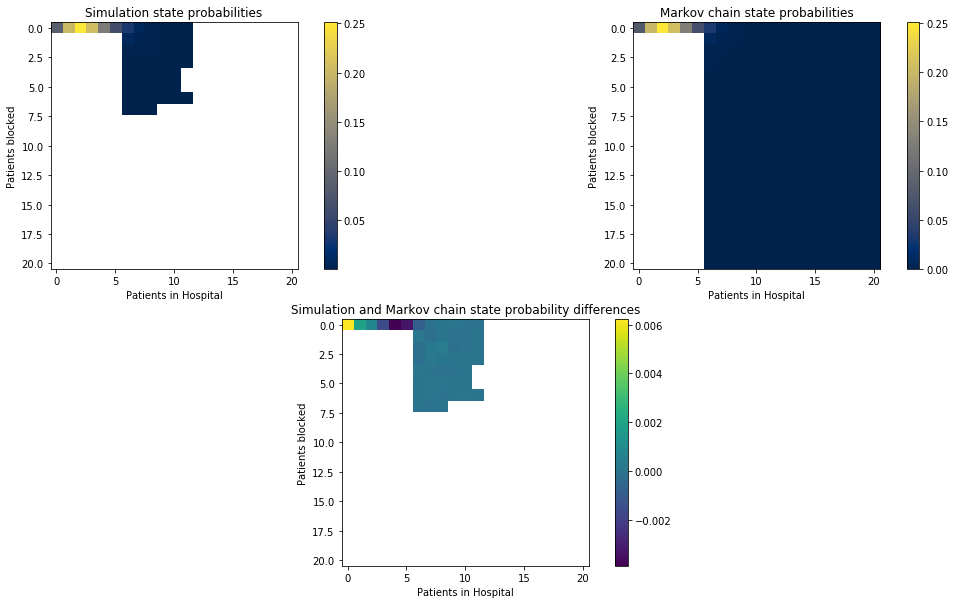

In [24]:
plt.figure(figsize=(20, 10))
abg.get_heatmaps(
    lambda_a,
    lambda_o=lambda_o,
    mu=mu,
    num_of_servers=num_of_servers,
    threshold=threshold,
    system_capacity=system_capacity,
    parking_capacity=parking_capacity,
    seed_num=seed_num,
    runtime=runtime,
    num_of_trials=num_of_trials,
)


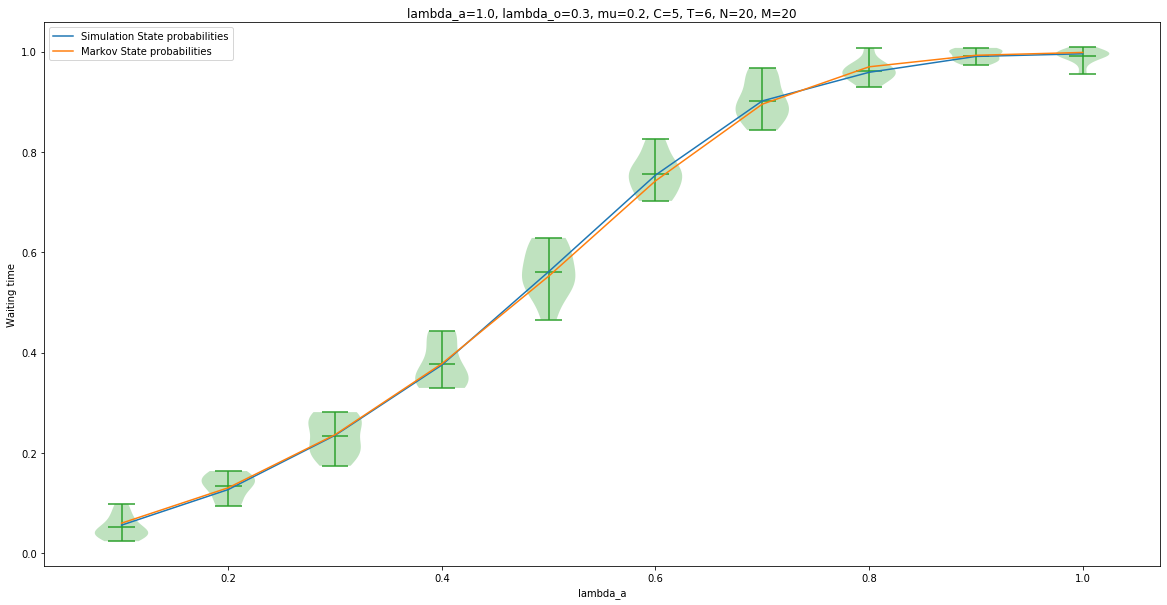

In [25]:
plot_over = "lambda_a"
max_parameter_value = 1
x_axis, mean_sim, mean_markov, all_sim = abg.get_plot_comparing_times(
    0.1,
    lambda_o,
    mu,
    num_of_servers,
    threshold,
    num_of_trials,
    seed_num,
    runtime,
    system_capacity,
    parking_capacity,
    output,
    plot_over,
    max_parameter_value,
    accuracy,
)


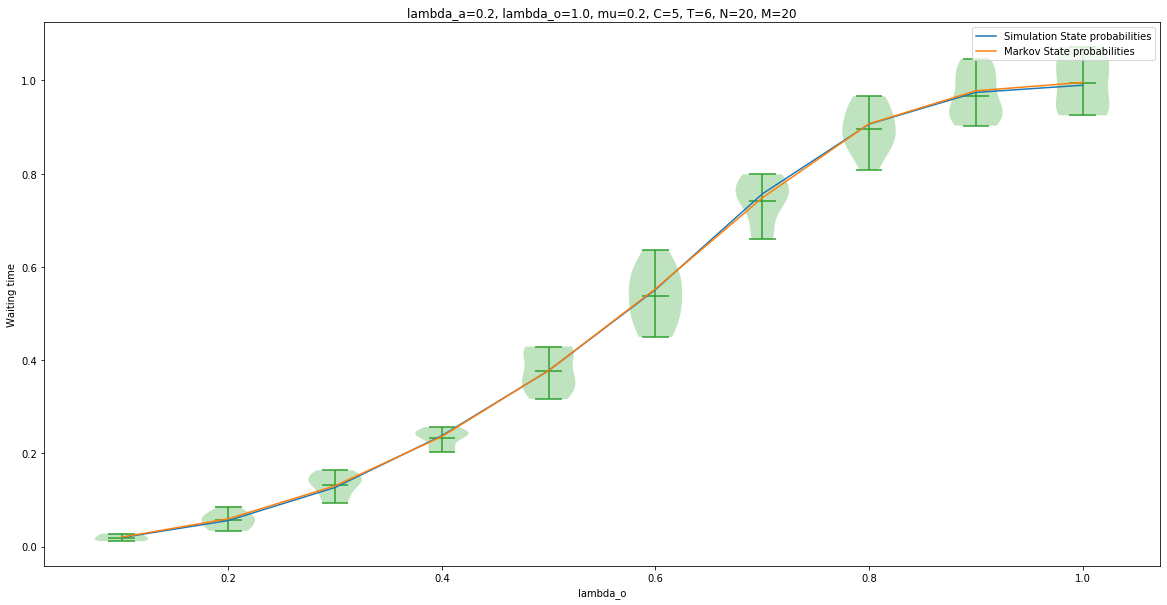

In [22]:
plot_over = "lambda_o"
max_parameter_value = 1
x_axis, mean_sim, mean_markov, all_sim = abg.get_plot_comparing_times(
    lambda_a,
    0.1,
    mu,
    num_of_servers,
    threshold,
    num_of_trials,
    seed_num,
    runtime,
    system_capacity,
    parking_capacity,
    output,
    plot_over,
    max_parameter_value,
    accuracy,
)

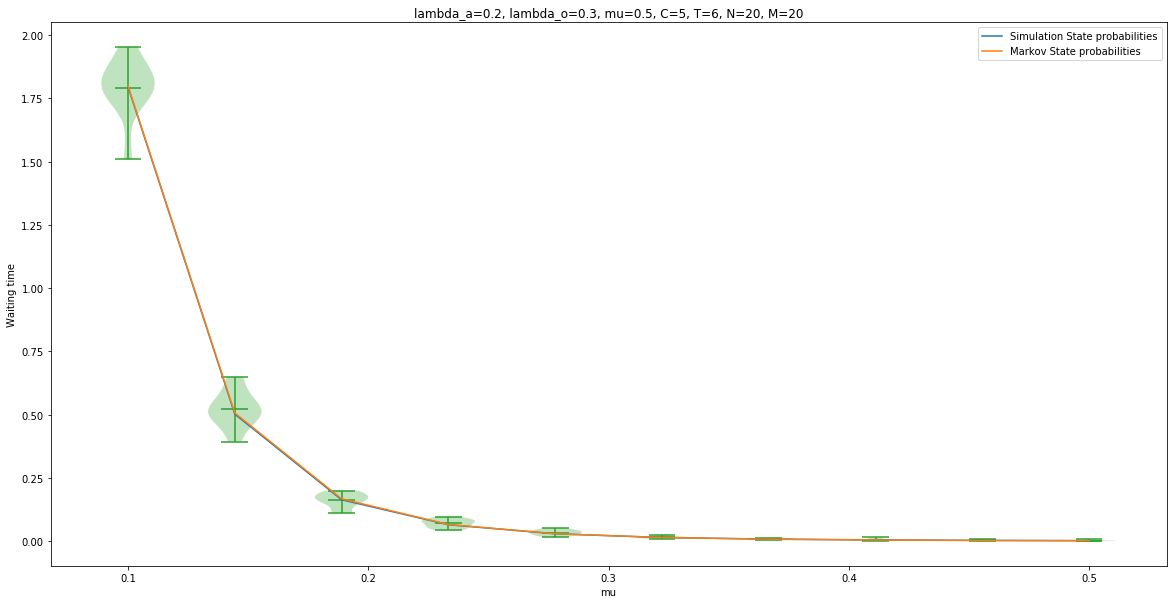

In [27]:
plot_over = "mu"
max_parameter_value = 0.5
x_axis, mean_sim, mean_markov, all_sim = abg.get_plot_comparing_times(
    lambda_a,
    lambda_o,
    0.1,
    num_of_servers,
    threshold,
    num_of_trials,
    seed_num,
    runtime,
    system_capacity,
    parking_capacity,
    output,
    plot_over,
    max_parameter_value,
    accuracy,
)


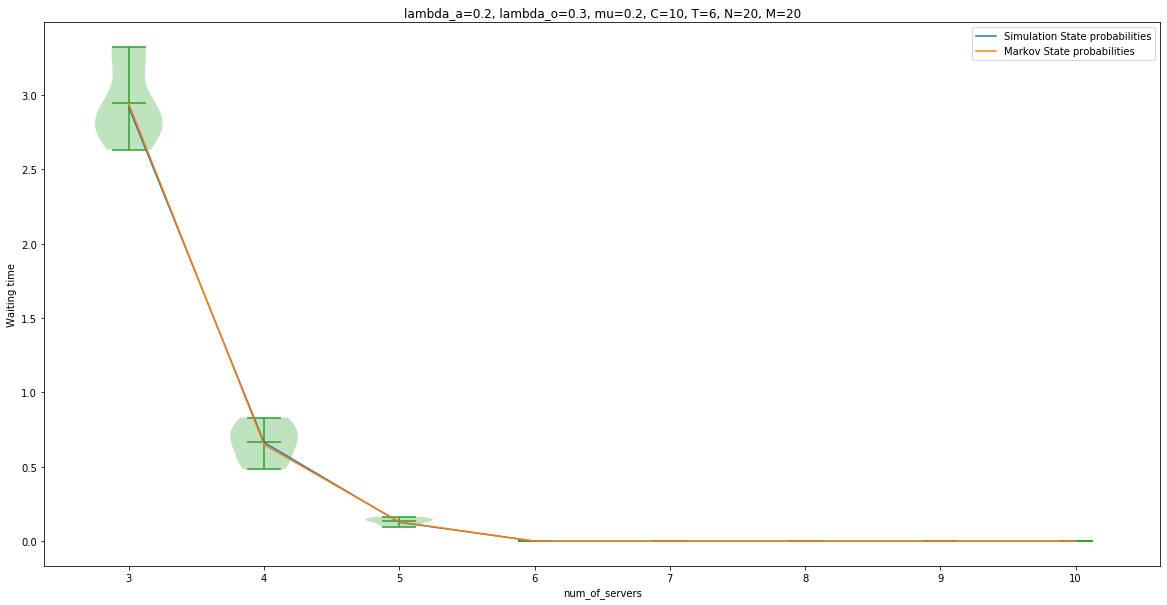

In [28]:
plot_over = "num_of_servers"
max_parameter_value = 10
x_axis, mean_sim, mean_markov, all_sim = abg.get_plot_comparing_times(
    lambda_a,
    lambda_o,
    mu,
    3,
    threshold,
    num_of_trials,
    seed_num,
    runtime,
    system_capacity,
    parking_capacity,
    output,
    plot_over,
    max_parameter_value,
    8,
)


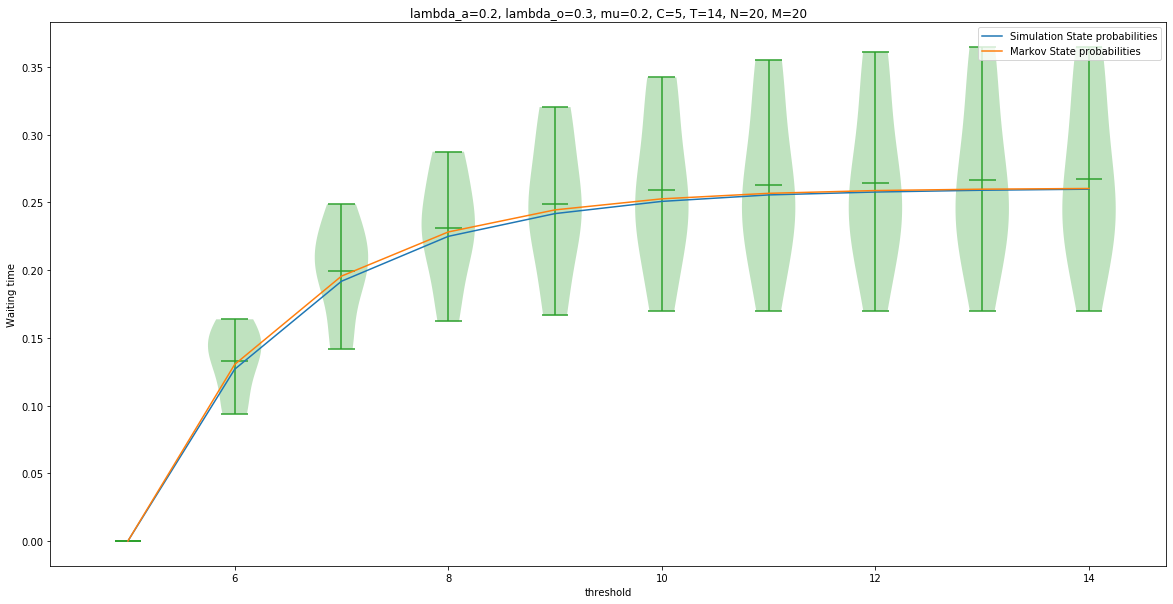

In [29]:
plot_over = "threshold"
max_parameter_value = 14
x_axis, mean_sim, mean_markov, all_sim = abg.get_plot_comparing_times(
    lambda_a,
    lambda_o,
    mu,
    num_of_servers,
    5,
    num_of_trials,
    seed_num,
    runtime,
    system_capacity,
    parking_capacity,
    output,
    plot_over,
    max_parameter_value,
    accuracy,
)


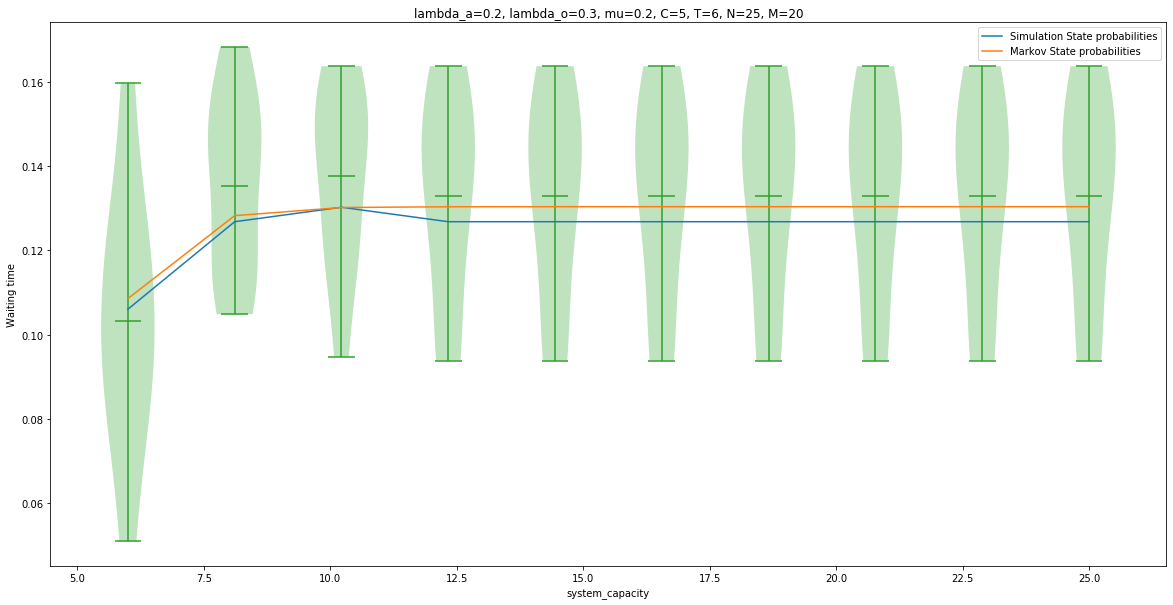

In [30]:
plot_over = "system_capacity"
max_parameter_value = 25
x_axis, mean_sim, mean_markov, all_sim = abg.get_plot_comparing_times(
    lambda_a,
    lambda_o,
    mu,
    num_of_servers,
    threshold,
    num_of_trials,
    seed_num,
    runtime,
    6,
    parking_capacity,
    output,
    plot_over,
    max_parameter_value,
    accuracy,
)


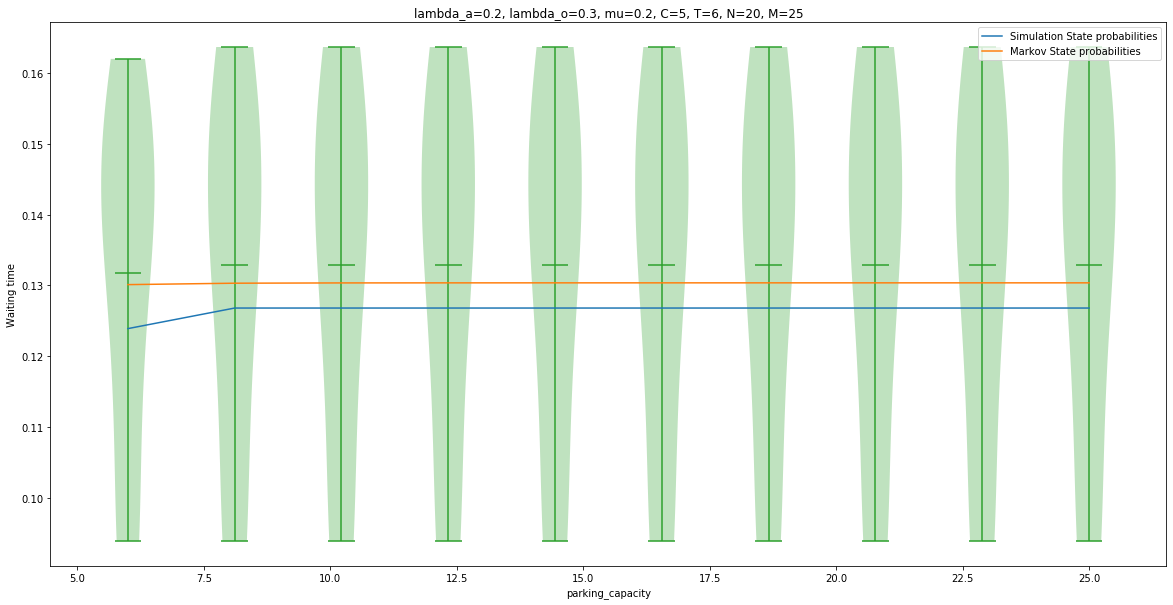

In [31]:
plot_over = "parking_capacity"
max_parameter_value = 25
x_axis, mean_sim, mean_markov, all_sim = abg.get_plot_comparing_times(
    lambda_a,
    lambda_o,
    mu,
    num_of_servers,
    threshold,
    num_of_trials,
    seed_num,
    runtime,
    system_capacity,
    6,
    output,
    plot_over,
    max_parameter_value,
    accuracy,
)


#### Both patients waiting times:


In [165]:
lambda_a = 0.2
lambda_o = 0.3
mu = 0.2
num_of_servers = 5
threshold = 6
system_capacity = 20
parking_capacity = 20

num_of_trials = 100
seed_num = None
runtime = 10000
output = "both"
accuracy = 10


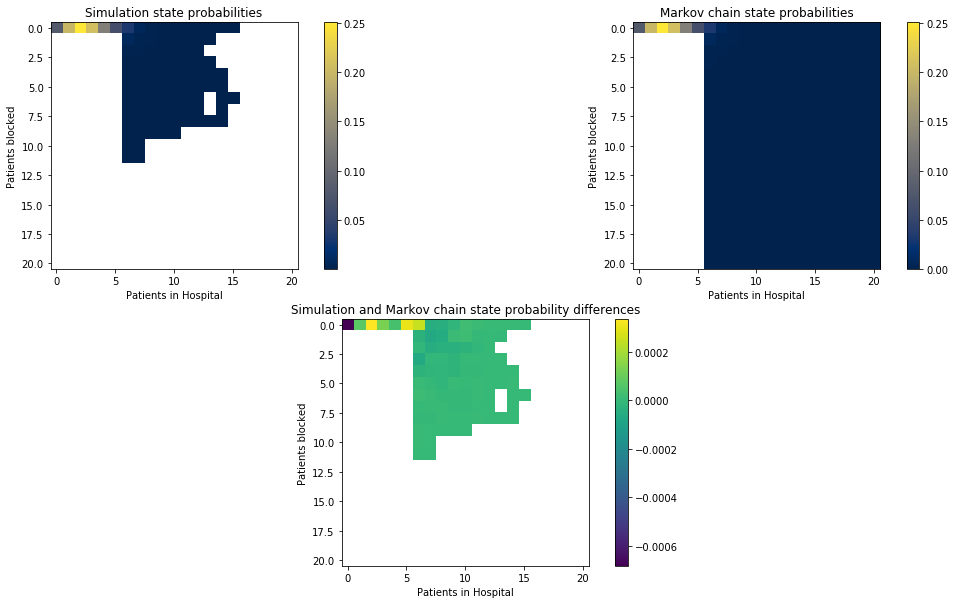

In [166]:
plt.figure(figsize=(20, 10))
abg.get_heatmaps(
    lambda_a,
    lambda_o=lambda_o,
    mu=mu,
    num_of_servers=num_of_servers,
    threshold=threshold,
    system_capacity=system_capacity,
    parking_capacity=parking_capacity,
    seed_num=seed_num,
    runtime=runtime,
    num_of_trials=num_of_trials,
)


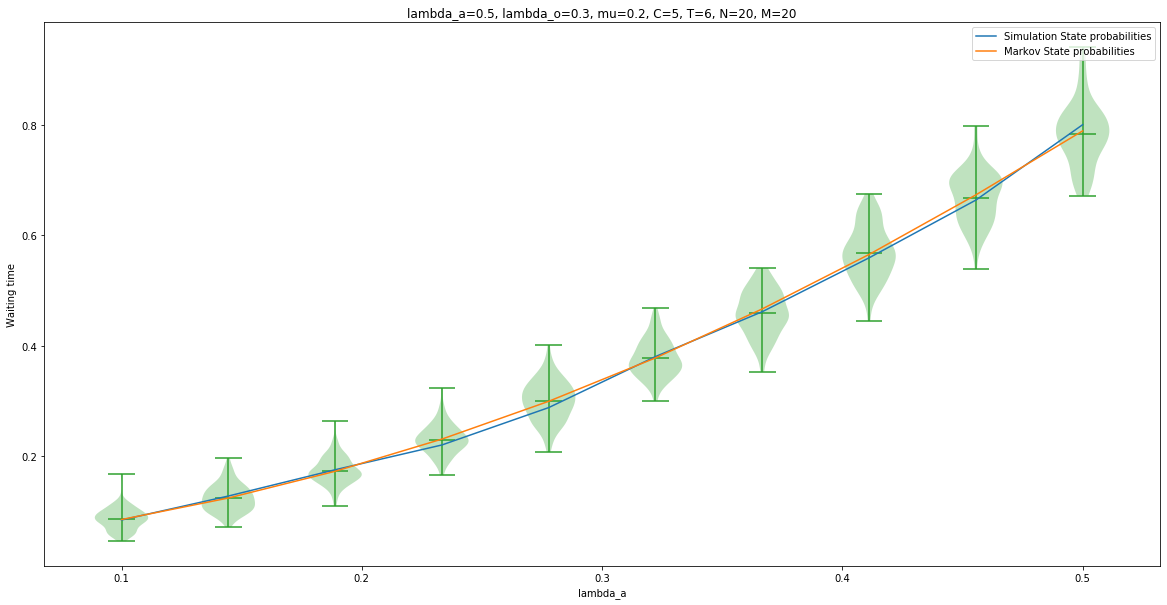

In [167]:
plot_over = "lambda_a"
max_parameter_value = 0.5
x_axis, mean_sim, mean_markov, all_sim = get_plot_comparing_times(
    0.1,
    lambda_o,
    mu,
    num_of_servers,
    threshold,
    num_of_trials,
    seed_num,
    runtime,
    system_capacity,
    parking_capacity,
    output,
    plot_over,
    max_parameter_value,
    accuracy,
)


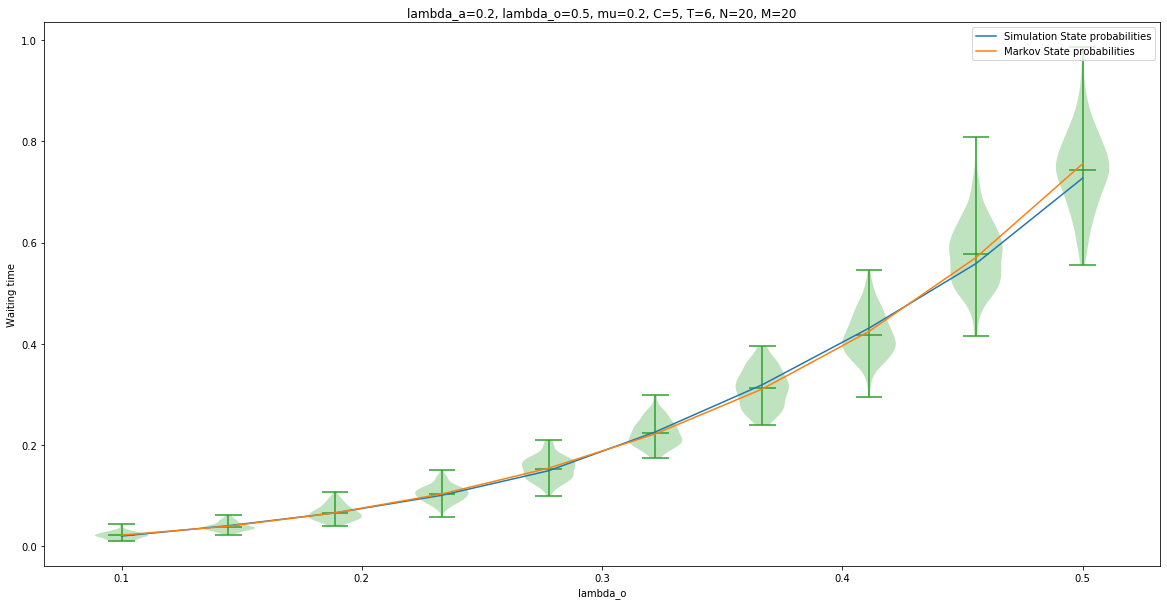

In [168]:
plot_over = "lambda_o"
max_parameter_value = 0.5
x_axis, mean_sim, mean_markov, all_sim = get_plot_comparing_times(
    lambda_a,
    0.1,
    mu,
    num_of_servers,
    threshold,
    num_of_trials,
    seed_num,
    runtime,
    system_capacity,
    parking_capacity,
    output,
    plot_over,
    max_parameter_value,
    accuracy,
)


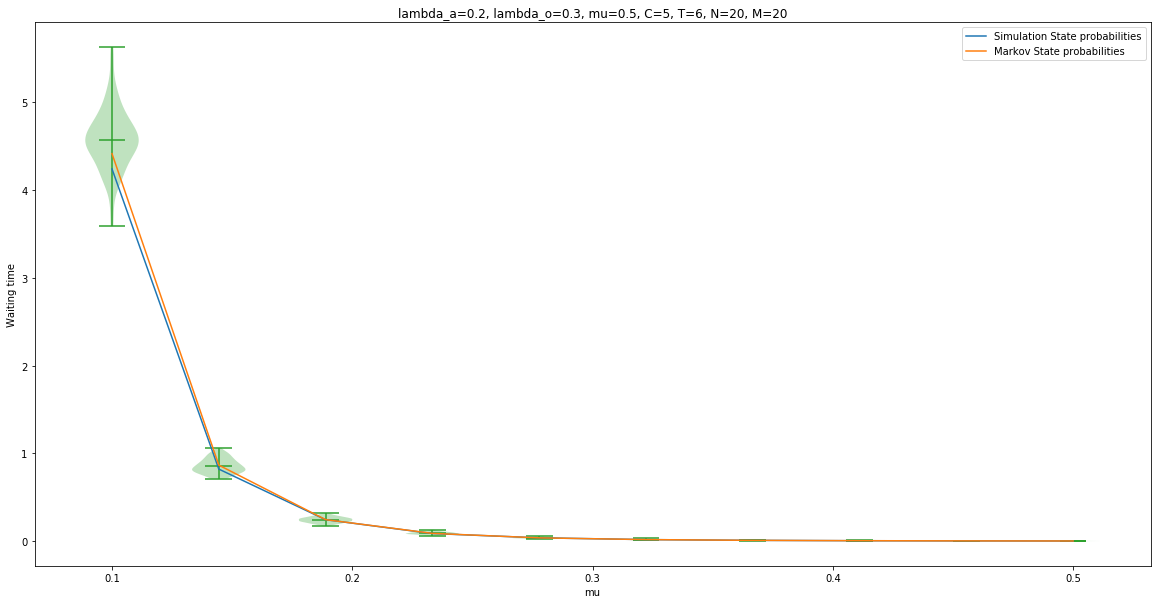

In [169]:
plot_over = "mu"
max_parameter_value = 0.5
x_axis, mean_sim, mean_markov, all_sim = get_plot_comparing_times(
    lambda_a,
    lambda_o,
    0.1,
    num_of_servers,
    threshold,
    num_of_trials,
    seed_num,
    runtime,
    system_capacity,
    parking_capacity,
    output,
    plot_over,
    max_parameter_value,
    accuracy,
)


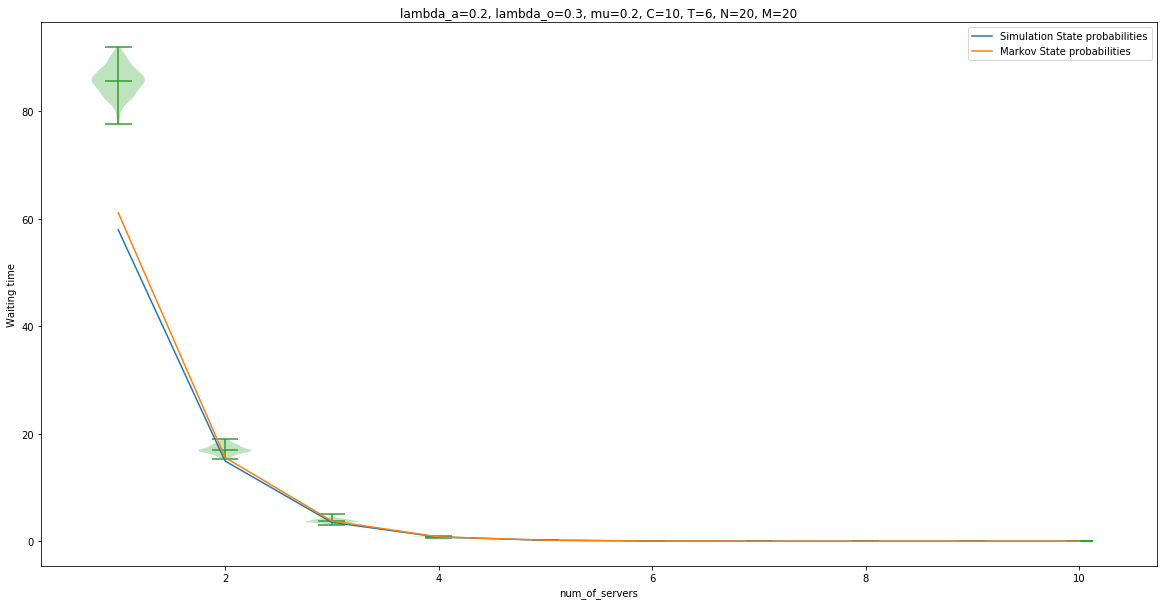

In [170]:
plot_over = "num_of_servers"
max_parameter_value = 10
x_axis, mean_sim, mean_markov, all_sim = get_plot_comparing_times(
    lambda_a,
    lambda_o,
    mu,
    1,
    threshold,
    num_of_trials,
    seed_num,
    runtime,
    system_capacity,
    parking_capacity,
    output,
    plot_over,
    max_parameter_value,
    accuracy,
)


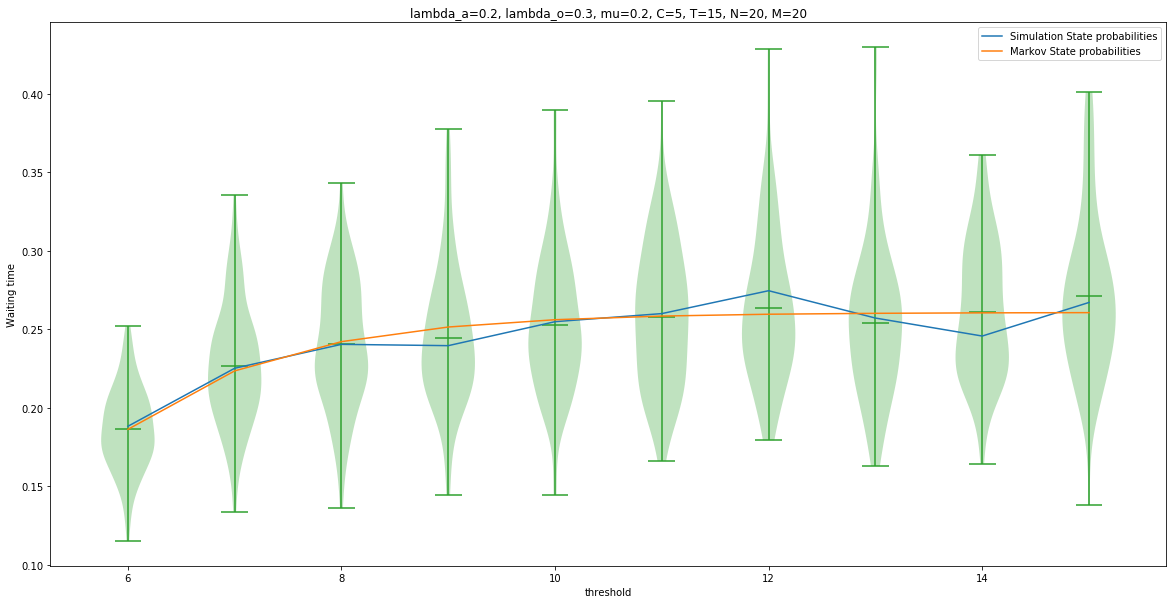

In [171]:
plot_over = "threshold"
max_parameter_value = 15
x_axis, mean_sim, mean_markov, all_sim = get_plot_comparing_times(
    lambda_a,
    lambda_o,
    mu,
    num_of_servers,
    6,
    num_of_trials,
    seed_num,
    runtime,
    system_capacity,
    parking_capacity,
    output,
    plot_over,
    max_parameter_value,
    accuracy,
)


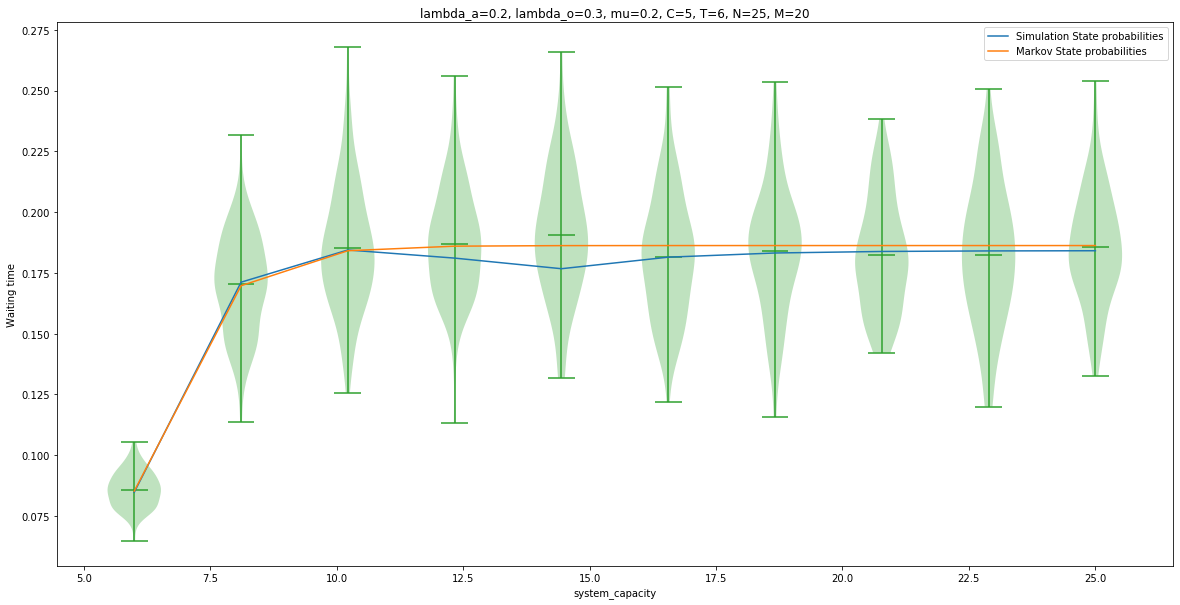

In [172]:
plot_over = "system_capacity"
max_parameter_value = 25
x_axis, mean_sim, mean_markov, all_sim = get_plot_comparing_times(
    lambda_a,
    lambda_o,
    mu,
    num_of_servers,
    threshold,
    num_of_trials,
    seed_num,
    runtime,
    6,
    parking_capacity,
    output,
    plot_over,
    max_parameter_value,
    accuracy,
)


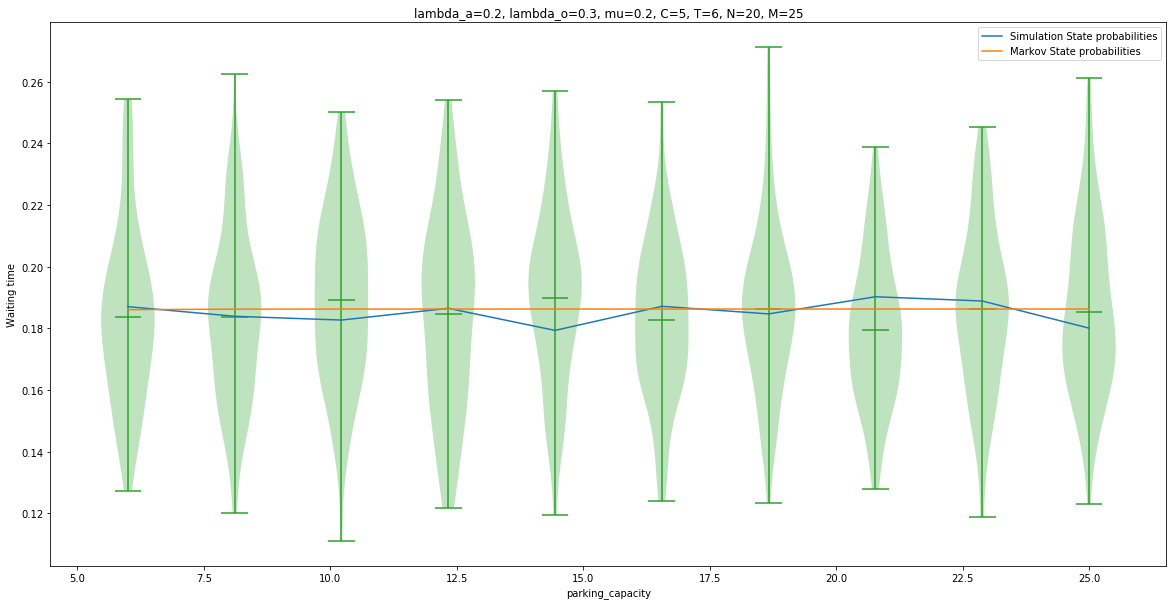

In [173]:
plot_over = "parking_capacity"
max_parameter_value = 25
x_axis, mean_sim, mean_markov, all_sim = get_plot_comparing_times(
    lambda_a,
    lambda_o,
    mu,
    num_of_servers,
    threshold,
    num_of_trials,
    seed_num,
    runtime,
    system_capacity,
    6,
    output,
    plot_over,
    max_parameter_value,
    accuracy,
)


# Playing around

In [8]:
import functools as fnc

In [16]:
@fnc.lru_cache(maxsize=None)
def fib(n, k):
    print(n)
    if n < 2:
        return n
    return fib(n-1, 1) + fib(n-2, 1)

In [18]:
[fib(n, 1) for n in range(16)]

[0, 1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377, 610]

In [20]:
[fib(n, 2) for n in range(16)]

[0, 1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377, 610]